**Import packages**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow import keras
from tensorflow.keras import layers
import datetime
import copy
import random
from collections import Counter
import gensim 
from gensim.models import Word2Vec
import gensim.models.doc2vec as doc2vec
from sklearn import model_selection

%matplotlib inline

from google.colab import drive

import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/Capstone')

Mounted at /content/drive


#1 Data preparing and processing

##1.1 Building and processing

In [ ]:
class data_process(): #the super class for two sub classes
  def __init__(self, seq_len=11): #the maximum sequence length
    self.act2id = {} #tokenizer: mapping from activity title to Id and its focus area
    self.id2act = {}
    self.seq_len = seq_len
    self.pre = None
    self.pro = None
  
  def set_tokenizer(self, df_filt): # set up two tokenizer mappings
    df_map = df_filt.drop_duplicates(subset=["activity_title"])
    df_map = df_map.sort_values(["activity_title"])
    df_map.reset_index(drop=True, inplace=True)
    
    for i,v in df_map.iterrows():
      self.act2id[v["activity_title"]] = (i+1, v["focus_area_combine"])
      self.id2act[i+1] = (v["activity_title"], v["focus_area_combine"])

  def process(self, sliced=False):
    if self.pre is None: #if the data is already preprocessed, skip doing again.
      df1 = self.preprocess()
    else:
      df1 = self.pre

    new = df1.groupby(by="user_id").agg(list).reset_index()
    new.columns=["user","activity_sequence", "focus_area_combine", "time_stamp"]
    new = new[new["time_stamp"].apply(lambda x: len(x)>=2)]

    if sliced: #whether to slice the koa data or not.
      new["user"] = new["user"].apply(lambda x: np.atleast_1d(x))
      new = self.df_slice(new, self.seq_len)

    new["time_dif"] = new["time_stamp"].apply(lambda x: np.diff(x)/pd.Timedelta(days=1))
    new["time_last"] =  new["time_stamp"].apply(lambda x: x[-1])
    new.drop(["time_stamp"], axis=1, inplace=True)
    new = new.sort_values(by=["time_last"])
    new.reset_index(drop=True, inplace=True)

    self.pro = new #save the processed data
    return new

  def get_target(self, sliced=False, use_all=False):
    if self.pro is None: #if data is alreayd processed, skip doing again
      new = self.process(sliced)
    else:
      new = self.pro

    target = new["activity_sequence"].apply(lambda x: self.act2id[x[-1]][0])
    newdf = new[["activity_sequence", "focus_area_combine"]]

    if not use_all: #if set true, use all the previous activities of users, otherwise use the maximum length.
      newdf = newdf.applymap(lambda x: x[-self.seq_len:-1])
    else:
      newdf = newdf.applymap(lambda x: x[:-1])
    
    newdf["time_dif"] = new["time_dif"]
    newdf["target"] = target
    newdf["user"] = new["user"]

    newdf["time_last"] = new["time_last"] 
    newdf["actId_sequence"] = newdf["activity_sequence"].apply(lambda x: [self.act2id[v][0] for v in x])
    return newdf
  
  def label_smoothing(self, use_all=False):#to use label smoothing regularization method, change target shapes to one-hot type.
    df = self.get_target(use_all=use_all)
    df["target"] = df["target"].apply(lambda x: self.get_one_hot(x, len(self.act2id)+1))
    return df

  def get_one_hot(self, targets, nb_classes): 
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(np.array(targets).shape)+[nb_classes])
  
  def save(self, file, sliced=False): #save the processed data and tokenizers 
    if self.pro is None:
      self.process(sliced)
    obj = {"preprocessed": self.pre,
           "processed": self.pro,
           "act2id":self.act2id,
           "id2act": self.id2act}
    pickle_out = open("Data/"+file, "wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()
  
  def load(self, file):#load the stored data.
    pickle_in = open("Data/"+file, "rb")
    obj = pickle.load(pickle_in)
    self.pre = obj["preprocessed"]
    self.pro = obj["processed"]
    self.act2id = obj["act2id"]
    self.id2act = obj["id2act"]

  def preprocess(self):
    pass

class koa_process(data_process):#child class for Koa data processing
  def __init__(self, focus_data, raw_koa):
    super().__init__()
    self.focus_data = focus_data
    self.raw_koa = raw_koa

  def koa_focus(self):# obtain focus area data
    cols = ['activity_id']
    for i in range(11):
      cols.append(self.focus_data['data'][i]['abbreviation'])

    act_list = []
    for i in range(11):
      act_list += self.focus_data["data"][i]["exercises"]

    unique_activities = sorted(list(set(act_list)))

    df_focus = pd.DataFrame(columns= cols)
    df_focus['activity_id'] = unique_activities
    for i in range(len(df_focus)):
      for j in range(11):
        if df_focus['activity_id'][i] in self.focus_data['data'][j]['exercises']:
          df_focus[cols[j+1]][i] = 1
        else:
          df_focus[cols[j+1]][i] = -1

    df_focus['focus_area_combine'] = df_focus[['RTO', 'TS','DSO' ,'HL' ,'FD','WRK', 'FO','LSE','BRN','AT','HT']].values.tolist()
    return df_focus
  
  def preprocess(self): 
    df_focus = self.koa_focus()
    df_raw = self.raw_koa.merge(df_focus[['activity_id','focus_area_combine']], on='activity_id', how='left')
    df_raw.dropna(inplace=True)

    df_sort = df_raw.sort_values(['user_id', 'created_at'], ascending=[True, True])
    df_sort_2 = df_sort[df_sort['event'] == 'tap']

    df_filt = df_sort_2[['user_id', 'activity_title', 'focus_area_combine', 'created_at']]
    df_filt.reset_index(drop=True, inplace=True)

    dup_row_ind = []
    for i in range(len(df_filt)-1):
      if df_filt.user_id[i] == df_filt.user_id[i+1] and df_filt.activity_title[i] == df_filt.activity_title[i+1]:
        dup_row_ind.append(i+1)
      
    df_filt.drop(dup_row_ind, axis = 0, inplace = True)
    df_filt.reset_index(drop=True, inplace=True)
    df_filt["created_at"] = df_filt["created_at"].astype('datetime64[ns]')

    #map activity title to integer
    self.set_tokenizer(df_filt)

    self.pre = df_filt
    return df_filt

  def df_slice(self, df, seq_len): #our attempting of slicing the koa data at the beginning.
    new = df.applymap(lambda x: self.seq_slice(x, seq_len))

    seq_map = {"activity_sequence": [], 
              "time_stamp": [],
              "focus_area_combine": [],
               "user": []}

    for i,v in new.iterrows():
      len_seq = len(v["activity_sequence"])
      for j in range(len_seq):
        seq_map["activity_sequence"].append(v["activity_sequence"][j])
        seq_map["time_stamp"].append(v["time_stamp"][j])
        seq_map["focus_area_combine"].append(v["focus_area_combine"][j])
        seq_map["user"].append(v["user"][0][0])
    new_pd = pd.DataFrame(data=seq_map)
    return new_pd

  def seq_slice(self, seq, seq_len):
    l = []
    num_split = max(len(seq) - seq_len, 0)
    if num_split:
      for i in range(num_split+1):
        l.append(seq[i:seq_len+i])
    else:
      l.append(seq)
    return l


class movie_process(data_process): #child class for MovieLens data processing
  def __init__(self, movie_data, rating_data):
    super().__init__()
    self.movie = movie_data
    self.rating = rating_data
    self.genres_list = None
  
  def genres_string_to_int(self, x): # obtain movie genres(similar to focus area)
    fc = []
    for genre in self.genres_list:
      if genre in x:
        fc.append(int(1))
      else:
        fc.append(int(-1))
    return fc

  def preprocess(self):
    counts = Counter(self.rating["movieId"])
    movie_ids = np.array(counts.most_common(130))[:,0]

    ind = self.rating["movieId"].apply(lambda x: x in movie_ids)
    new_r = self.rating[ind]
    new_r = new_r.loc[new_r["rating"]>=3]
    np.unique(new_r["userId"],return_counts=True)

    new_r_joined = new_r.merge(self.movie[['movieId','title','genres']], on="movieId", how='left')
    new_r_joined['created_at'] = new_r_joined.timestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    new_r_joined.genres = new_r_joined.genres.apply(lambda x: x.split('|'))

    out = []
    for sublist in new_r_joined.genres:
        out.extend(sublist)
    self.genres_list = sorted(list(set(out)))
    new_r_joined.genres = new_r_joined.genres.apply(lambda x: self.genres_string_to_int(x))

    movie_df_sort = new_r_joined[['userId', 'title', 'genres', 'created_at']]
    movie_df_sort.columns = ['user_id', 'activity_title', 'focus_area_combine', 'created_at']
    movie_df_filt = movie_df_sort.sort_values(['user_id','created_at'], ascending=[True, True])
    movie_df_filt.reset_index(drop=True, inplace=True)

    #map activity title to integer
    self.set_tokenizer(movie_df_filt)

    movie_df_filt.drop_duplicates(subset=["user_id", "activity_title"], keep="last", inplace=True)
    self.pre = movie_df_filt 

    return movie_df_filt 

**Loading raw data**

In [ ]:
r_data = pd.read_csv("Data/ratings.csv")
m_data = pd.read_csv("Data/movies.csv")
focus_raw = pd.read_json('focus_areas_en_US.json',encoding='utf-8-sig')
koa_df_raw = pd.read_parquet('Data/lse21.parquet')

**Movielens data processing**

In [ ]:
obj_movie = movie_process(m_data, r_data)

In [ ]:
obj_movie.preprocess()

In [ ]:
obj_movie.process()

In [ ]:
obj_movie.get_target()

**Store and read the processed movielens data object**

In [ ]:
obj_movie = movie_process(m_data, r_data)
obj_movie.save("movie_pkl")

In [ ]:
obj_movie = movie_process(1, 2)
obj_movie.load("movie_pkl_2.5w")

In [ ]:
obj_movie.get_target()

**Koa data processing**

In [ ]:
obj_koa = koa_process(focus_raw, koa_df_raw)
obj_koa.save("koa_pkl_sliced", True) #set True to save the sliced data frame

In [ ]:
obj_koa = koa_process(focus_raw, koa_df_raw)
obj_koa.load("koa_pkl")

In [ ]:
obj_koa.label_smoothing(target_seq=True)

In [ ]:
obj_koa.get_target()

In [ ]:
obj_koa = koa_process(focus_raw, koa_df_raw)
obj_koa.save("koa_pkl") #default is False

## 1.2 Prepare for NLP models

In [ ]:
class RNN_prepare(): #the class to prepare data such that it can be fed into neural network and RNN-based network.
  def __init__(self, df_rnn):
    self.df_rnn = df_rnn #this should be the data frame with targets. e.g,after using get_target() or label_smoothing() function.
    self.maxlen = df_rnn["actId_sequence"].apply(lambda x: len(x)).max()
    self.target = np.array(df_rnn['target'].tolist())
    self.dataset = {}

  def pad(self): #pad inputs
    act_inputs = self.df_rnn['actId_sequence'].tolist()
    nd_input = self.df_rnn['time_dif'].tolist()
    focus_inputs = self.df_rnn['focus_area_combine'].tolist()

    act_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(act_inputs, padding="pre", maxlen = self.maxlen)
    nd_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(nd_input, padding="pre", maxlen = self.maxlen)
    focus_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(focus_inputs, padding="pre", maxlen = self.maxlen)
    self.dataset["act_id"] = act_inputs_padded
    self.dataset["time_dif"] = nd_inputs_padded
    self.dataset["focus_area"] = focus_inputs_padded

  def cross_split(self, kfold): #train/test split for 5-fold cross evaluation
    self.pad() #run padding function
    act_inputs_padded = self.dataset["act_id"]
    nd_inputs_padded = self.dataset["time_dif"]
    focus_inputs_padded = self.dataset["focus_area"]
    num_samples = act_inputs_padded.shape[0]

    num_eachfold = np.floor(num_samples/5)

    hold_ind = np.arange((kfold-1)*num_eachfold, kfold*num_eachfold).astype(int)
    train_ind = np.array(list( set(np.arange(num_samples)) - set(hold_ind) ) )
    val_ind, test_ind = model_selection.train_test_split(hold_ind, test_size=0.5)
    target_train = self.target[train_ind]
    target_val = self.target[val_ind]
    target_test = self.target[test_ind]

    train_dict = {'act_id': act_inputs_padded[train_ind],
              'time_dif': nd_inputs_padded[train_ind],
              'focus_area': focus_inputs_padded[train_ind]}
    train_set = tf.data.Dataset.from_tensor_slices((train_dict, target_train))

    val_dict = {'act_id': act_inputs_padded[val_ind],
              'time_dif': nd_inputs_padded[val_ind],
              'focus_area': focus_inputs_padded[val_ind]}
    val_set = tf.data.Dataset.from_tensor_slices((val_dict, target_val))

    test_dict = {'act_id': act_inputs_padded[test_ind],
              'time_dif': nd_inputs_padded[test_ind],
              'focus_area': focus_inputs_padded[test_ind]}
    test_set = tf.data.Dataset.from_tensor_slices((test_dict, target_test))
    return train_set, val_set, test_set, target_test

  def random_split(self):#random split by 0.8/0.1/0.1
    self.pad()
    act_inputs_padded = self.dataset["act_id"]
    nd_inputs_padded = self.dataset["time_dif"]
    focus_inputs_padded = self.dataset["focus_area"]
    num_samples = act_inputs_padded.shape[0]

    train_ind, hold_ind = model_selection.train_test_split(np.arange(num_samples), test_size=0.2)
    val_ind, test_ind =  model_selection.train_test_split(hold_ind, test_size=0.5)

    target_train = self.target[train_ind]
    target_val = self.target[val_ind]
    target_test = self.target[test_ind]

    train_dict = {'act_id': act_inputs_padded[train_ind],
              'time_dif': nd_inputs_padded[train_ind],
              'focus_area': focus_inputs_padded[train_ind]}
    train_set = tf.data.Dataset.from_tensor_slices((train_dict, target_train))

    val_dict = {'act_id': act_inputs_padded[val_ind],
              'time_dif': nd_inputs_padded[val_ind],
              'focus_area': focus_inputs_padded[val_ind]}
    val_set = tf.data.Dataset.from_tensor_slices((val_dict, target_val))

    test_dict = {'act_id': act_inputs_padded[test_ind],
              'time_dif': nd_inputs_padded[test_ind],
              'focus_area': focus_inputs_padded[test_ind]}
    test_set = tf.data.Dataset.from_tensor_slices((test_dict, target_test))
    return train_set, val_set, test_set, target_test

# 2 Embedding layer

In [ ]:
class Embedding(): #super class for three child embedding classes
  def __init__(self, obj):
    self.obj = obj #the data_process class object
    self.emb_matrix = None
    self.title2vec = None
    self.tokenizer = None
    self.model = None
    self.seq_list = None

  def set_obj(self): # set up object
    if self.obj.pro is None:
      self.seq_list = list(self.obj.process().activity_sequence)
    else:
      self.seq_list = self.obj.pro
      
    self.tokenizer = self.obj.act2id
    self.id2act = self.obj.id2act
    self.act_list = self.obj.act2id.keys()

  def build_matrix(self): #build embedding weights matrix
    if self.model is None:
      self.model_opt()

    if self.emb_matrix is not None:
      self.emb_matrix = np.vstack(( np.zeros((1, self.emb_matrix.shape[1])), self.emb_matrix))
    matrix = []
    for act in self.act_list:
      vec = self.encode(act)
      matrix.append(vec)
    matrix = np.array(matrix)
    self.emb_matrix = np.vstack(( np.zeros((1, matrix.shape[1])), matrix))

  def build_t2v(self): #convert activity title to embedding vector, store this mapping to save computation.
    if self.model is None:
      self.model_opt()
    
    title2vec = {}
    for act in self.act_list:
      vec = self.encode(act)
      title2vec[act] = vec
    self.title2vec = title2vec

  def save(self, file):#save the corresponding embedding  
    if self.emb_matrix is None:
      self.build_matrix()
    
    if self.title2vec is None:
      self.build_t2v()

    obj = {"emb_matrix": self.emb_matrix,
           "title2vec": self.title2vec}
    pickle_out = open("Pre_trained/"+file,"wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()
  
  def load(self, file): #load the corresponding embedding 
    pickle_in = open("Pre_trained/"+file,"rb")
    obj = pickle.load(pickle_in)
    self.emb_matrix = obj["emb_matrix"]
    self.title2vec = obj["title2vec"]

  def model_opt(self):
    pass
  
  def encode(self):
    pass

class Doc2Vec(Embedding): #child class for Doc2Vec embedding
  def __init__(self, obj, model):
    super().__init__(obj)
    self.model_sub = model #the pretrained model

  def model_opt(self):
    if self.tokenizer is None:
      self.set_obj()
    self.model = self.model_sub

  def encode(self, activity):
    if self.model is None:
      self.model_opt()
    return self.model.infer_vector(activity)

class SBERT(Embedding):#child class for SBERT embedding 
  def __init__(self, obj, model_list):
    super().__init__(obj)
    self.model_list = model_list #SBERT models to be compared
  
  def emb_loss(self, model, act_appeared): #loss function used to compare SBERT embeddings
    loss = 0
    emb_matrix = []
    for act in act_appeared:
      emb_matrix.append(model.encode(act))
    emb_matrix = np.array(emb_matrix)

    for i in range(emb_matrix.shape[0]):
      dot_prod_sim = np.matmul(emb_matrix[i], np.transpose(np.delete(emb_matrix, i, axis=0)))
      top_10_idx = np.argsort(dot_prod_sim)[-10:]
      for idx in top_10_idx:
        loss += np.linalg.norm(np.array(self.id2act[idx+1][1]) - np.array(self.id2act[i+1][1]))
    return loss, emb_matrix

  def model_opt(self):# choose the best SBERT embedding
    if self.tokenizer is None:
      self.set_obj()
    
    best_loss = float("inf")

    for model in self.model_list:
      current_loss, matrix = self.emb_loss(model, self.act_list)
      if current_loss < best_loss:
        self.model = model
        self.emb_matrix = matrix
        self.emb_size = matrix.shape[1]
        best_loss = current_loss
    
  def encode(self, activity):
    if self.model is None:
      self.model_opt()
    return self.model.encode(activity)

class Act2Vec(Embedding):#child class for Act2Vec embedding
  def __init__(self, obj, batch_words=30):
    super().__init__(obj)
    self.batch_words = batch_words #word2vec training argument

  def model_opt(self):#choose the best Act2Vec embedding dimension 
    if self.tokenizer is None:
      self.set_obj()

    emb_sizes = 2**np.arange(1,10)
    best_loss = float("inf")

    for emb_size in emb_sizes[1:]:
      avg_loss = []
      for i in range(10):
        model = Word2Vec(self.seq_list, size=emb_size, window=2, negative=4, min_count=1, batch_words=self.batch_words)
        avg_loss.append(self.emb_loss(model, self.act_list))
      current_loss = np.mean(avg_loss)
      if current_loss < best_loss:
        self.model = model
        self.emb_size = emb_size
        best_loss = current_loss
  
  def emb_loss(self, model, act_appeared):#loss function for different embedding dimensions
    loss = 0
    for act in act_appeared:
      sim_10 = model.wv.most_similar(positive=act)
      for i in sim_10:
        text = i[0]
        loss += np.linalg.norm(np.array(self.tokenizer[act][1]) - np.array(self.tokenizer[text][1]) )
    return loss

  def encode(self, activity):
    if self.model is None:
      self.model_opt()
    return self.model.wv[activity]

## 2.1 Self-trained Act2vec

In [ ]:
obj_koa = koa_process(focus_raw, koa_df_raw)
obj_Act2Vec = Act2Vec(obj_koa)

In [ ]:
obj_Act2Vec.build_matrix()

In [ ]:
obj_Act2Vec.build_t2v()

In [ ]:
obj_Act2Vec.emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00121335, -0.01179544,  0.0066008 , ...,  0.01090964,
         0.00875171, -0.00902294],
       [-0.01489708,  0.01353789,  0.01389517, ...,  0.00362536,
        -0.00832709, -0.01225774],
       ...,
       [-0.01453649,  0.00802768, -0.00895953, ..., -0.00757337,
         0.01587437,  0.0012947 ],
       [-0.00249845, -0.00380208,  0.01461971, ...,  0.00042108,
        -0.005129  ,  0.00763279],
       [ 0.00230336, -0.00829121, -0.01215704, ..., -0.00297776,
         0.0033068 ,  0.00821085]])

In [ ]:
obj_Act2Vec.title2vec

**Save and load**

In [ ]:
obj_koa = koa_process(focus_raw, koa_df_raw)
obj_movie = movie_process(m_data, r_data)
koa_Act2Vec = Act2Vec(obj_koa)
movie_Act2Vec = Act2Vec(obj_movie, 10000)
koa_Act2Vec.save("koa_Act2Vec")
movie_Act2Vec.save("movie_Act2Vec")

In [ ]:
koa_Act2Vec = Act2Vec(obj_koa)
movie_Act2Vec = Act2Vec(obj_movie)
koa_Act2Vec.load("koa_Act2Vec")
movie_Act2Vec.load("movie_Act2Vec")

In [ ]:
koa_Act2Vec.emb_matrix.shape

(131, 4)

In [ ]:
pretrained_weights_matrix = movie_Act2Vec.emb_matrix

In [ ]:
vocab_size, embedding_size = pretrained_weights_matrix.shape

## 2.2 Pre-trained Doc2vec

**Save**

In [ ]:
D2V_model = doc2vec.Doc2Vec.load("Pre_trained/doc2vec.bin")
koa_Doc2Vec = Doc2Vec(obj_koa, D2V_model)
movie_Doc2Vec = Doc2Vec(obj_movie, D2V_model)
koa_Doc2Vec.save("koa_Doc2Vec")
movie_Doc2Vec.save("movie_Doc2Vec")

**Load**

In [ ]:
koa_Doc2Vec = Doc2Vec(obj_koa, D2V_model)
movie_Doc2Vec = Doc2Vec(obj_movie, D2V_model)
koa_Doc2Vec.load("koa_Doc2Vec")
movie_Doc2Vec.load("movie_Doc2Vec")

## 2.3 Pre-trained Sentence BERT

In [ ]:
pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model1 = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
model2 = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d')

**Save**

In [ ]:
model_list = [model1, model2]
koa_SBERT = SBERT(obj_koa, model_list)
movie_SBERT = SBERT(obj_movie, model_list)
koa_SBERT.save("koa_SBERT")
movie_SBERT.save("movie_SBERT")

**Load**

In [ ]:
model_list = [model1, model2]
koa_SBERT = SBERT(obj_koa, model_list)
movie_SBERT = SBERT(obj_movie, model_list)
koa_SBERT.load("koa_SBERT")
movie_SBERT.load("movie_SBERT")

In [ ]:
koa_SBERT.emb_matrix.shape

(131, 768)

In [ ]:
movie_SBERT.emb_matrix.shape

(131, 768)

# 3 Models

##3.1 RNN

In [ ]:
class Model_LSTM(keras.layers.Layer): #LSTM model
  def __init__(self, dim, reg, Bidirection=False):
    super().__init__()
    if Bidirection:
      self.lstm = keras.layers.Bidirectional(keras.layers.LSTM(dim, return_sequences=True, stateful=False, recurrent_regularizer = reg))
    else:
      self.lstm = keras.layers.LSTM(dim, return_sequences=True, stateful=False, recurrent_regularizer = reg)
  def call(self,input):
    return self.lstm(input)

In [ ]:
class Model_GRU(keras.layers.Layer): #GRU model
  def __init__(self, dim, reg, Bidirection=False):
    super().__init__()
    if Bidirection:
      self.gru = keras.layers.Bidirectional(keras.layers.GRU(dim, return_sequences=True, stateful=False, recurrent_regularizer = reg))
    else:
      self.gru = keras.layers.GRU(dim, return_sequences=True, stateful=False, recurrent_regularizer = reg)
  def call(self,input):
    return self.gru(input)

## 3.3 Transformer

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model, batch_size):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  d0 = angle_rads.shape[0] #the length of the sequence
  d1 = angle_rads.shape[1] #the dimension of the embedding 
  pos_encoding = tf.broadcast_to(angle_rads, (batch_size, d0, d1))

  return tf.cast(pos_encoding, dtype=tf.float32)

def get_padding_mask(seq_k, seq_q):
    # Expand to fit the shape of key query attention matrix.
    seq_k = tf.reduce_sum(seq_k, axis=2)
    seq_q = tf.reduce_sum(seq_q, axis=2)
    len_q = seq_q.shape[1]
    k1 = seq_k.shape[0] #batch size
    k2 = seq_k.shape[1] #seq length
    padding_mask = tf.cast(tf.math.equal(seq_k, 0), tf.float32)
    padding_mask = tf.broadcast_to(padding_mask[:,np.newaxis, np.newaxis,:], (k1, 2, len_q, k2))
    return padding_mask

def create_padding_mask(seq, num_heads):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  d1 = seq.shape[0]
  d2 = seq.shape[1]
  padding_mask = tf.broadcast_to(seq[:, np.newaxis,np.newaxis,:], (d1, num_heads, d2,d2))
  return padding_mask

def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    #Split the last dimension into (num_heads, depth)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)


    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2
  
class transformer_enc(tf.keras.layers.Layer):
  def __init__(self,*, batch_size, num_layers, d_model, num_heads, dff, seq_length, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.seq_len = seq_length
    self.bs = batch_size

    self.pos_encoding = positional_encoding(seq_length, self.d_model, batch_size)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    #input here is already the output from embedding layer 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :self.seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x 

#4.Training and evaluation

In [ ]:
class Train_model(): #class for model building, training and testing
  def __init__(self, seq_len=11): #the maximum sequence length, change it will invoke data_process()
    self.data = None
    self.seq_len = seq_len
    self.emb = None

  def get_dataset(self, dataset):#load the processed dataset
    self.data = data_process(self.seq_len)
    self.data.load(dataset)
  
  def get_embedding(self, embedding, dataset="koa_pkl"):#build embedding weights matrix and embedding mapping
    if self.data is None:
      self.get_dataset(dataset)#if dataset is not loaded, load it here, do not need to call get_dataset
    
    if self.emb is None:
      self.emb = Embedding(self.data)
      self.emb.load(embedding)
    self.emb_matrix = self.emb.emb_matrix
    self.vocab_size, self.emb_size = self.emb_matrix.shape
  
  def loss_1(self, real, pred):#categorical cross entropy for one-hot type target
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=self.smoothing)
    loss = loss_f(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

  def loss_2(self, real, pred):#sparse categorical cross entropy for single integer type target
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_f = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = loss_f(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)
  
  def data_prepare(self, batch_size, dataset="koa_pkl", smoothing=0., kfold=0): #prepare data for NLP task
    if self.data is None:
      self.get_dataset(dataset)
    if smoothing:
      rnn_obj = RNN_prepare(self.data.label_smoothing())
    else:
      rnn_obj = RNN_prepare(self.data.get_target())
    self.smoothing = smoothing

    if kfold:
      train_set, val_set, test_set, target_test = rnn_obj.cross_split(kfold)
    else:
      train_set, val_set, test_set, target_test = rnn_obj.random_split()

    self.batch_size = batch_size
    buffer_size = len(train_set)//batch_size
    self.steps = len(train_set) // batch_size

    self.train_dataset = train_set.shuffle(buffer_size).batch(batch_size, drop_remainder = True)
    self.val_dataset = val_set.shuffle(buffer_size).batch(batch_size, drop_remainder = True)

    self.test_set = test_set
    self.target_test = target_test
  
  def build_Transformer(self, num_layers, num_heads, dff, dropout, lr, time_dif=False, focus_area=False):
    #function to build transformer architecture
    inputs = {}
    dim_1 = self.seq_len-1
    inputs['act_id'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1),name='act_id', dtype=tf.int32)
    ## Create encoding padding mask
    padding_mask = create_padding_mask(inputs["act_id"], num_heads)

    embedding_input = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.emb_size, 
                      weights=[self.emb_matrix], trainable=True, mask_zero = True, name='embedding_act')(inputs['act_id'])
    
    if time_dif:
      inputs['time_dif'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 1),name='num_days', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['time_dif']])

    if focus_area:
      inputs['focus_area'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 11),name='focus', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['focus_area']])

    transformer = transformer_enc(batch_size=self.batch_size, num_layers=num_layers, d_model=self.emb_size,
                                  num_heads=num_heads, dff=dff, seq_length=dim_1, rate=dropout)(embedding_input, True, padding_mask)

    Re = tf.reduce_sum(transformer, axis=1)
    Re = tf.keras.layers.Dropout(dropout)(Re, training=True)

    output = tf.keras.layers.Dense(131, name='output', activation='softmax')(Re)

    network = tf.keras.Model(inputs, output) 
    
    if self.smoothing: #to use label smoothing or not
      loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=self.smoothing)
    else:
      loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['accuracy'])
    self.network = network
    return network

  def build_NN(self, dropout_rate, lr, time_dif=False, focus_area=False):
    #build feedforward network
    inputs = {}
    dim_1 = self.seq_len-1
    inputs['act_id'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1),name='act_id', dtype=tf.int32)
    embedding_input = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.emb_size, 
                      weights=[self.emb_matrix], trainable=True, name='embedding_act')(inputs['act_id'])
    
    if time_dif:
      inputs['time_dif'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 1),name='num_days', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['time_dif']])

    if focus_area:
      inputs['focus_area'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 11),name='focus', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['focus_area']])

    nn = tf.reduce_sum(embedding_input, axis=1)
    nn = tf.keras.layers.Dropout(dropout_rate)(nn, training=True)
    nn = tf.keras.layers.Dense(256, name="hidden", activation="relu")(nn)
    nn = tf.keras.layers.Dropout(dropout_rate)(nn, training=True)
    output = tf.keras.layers.Dense(self.vocab_size, name='output', activation='softmax')(nn)
    network = tf.keras.Model(inputs, output) 

    if self.smoothing:
      loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=self.smoothing)
    else:
      loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['accuracy'])
    self.network = network
    return network

  def build_LSTM(self, model, dropout_rate, lr, time_dif=False, focus_area=False):
    #build self-attentive LSTM network
    inputs = {}
    dim_1 = self.seq_len-1
    inputs['act_id'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1),name='act_id', dtype=tf.int32)
    embedding_input = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.emb_size, 
                      weights=[self.emb_matrix], trainable=True, mask_zero = True, name='embedding_act')(inputs['act_id'])

    encoding_padding_mask = tf.math.logical_not(tf.math.equal(inputs['act_id'], 0))

    if time_dif:
      inputs['time_dif'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 1),name='num_days', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['time_dif']])

    if focus_area:
      inputs['focus_area'] = tf.keras.Input(batch_input_shape=(self.batch_size, dim_1, 11),name='focus', dtype=tf.float32)
      embedding_input = tf.keras.layers.Concatenate(name='concat_embedding_input')([embedding_input, inputs['focus_area']])

    embedding_input = tf.keras.layers.Masking(mask_value=0.)(embedding_input)

    rnn = model(embedding_input)
    rnn = tf.keras.layers.Dropout(dropout_rate)(rnn, training=True)
    
    rnn= tf.keras.layers.Attention(use_scale=False, causal=True, name='attention')(inputs=[rnn, rnn], mask=[encoding_padding_mask,encoding_padding_mask])
    rnn = tf.reduce_sum(rnn, axis=1)
    rnn = tf.keras.layers.Dropout(dropout_rate)(rnn, training=True)
    

    output = tf.keras.layers.Dense(self.vocab_size, name='output', activation='softmax')(rnn)

    network = tf.keras.Model(inputs, output) 

    loss_fn = self.loss_1 if self.smoothing else self.loss_2

    network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['accuracy'])
    self.network = network
    return network
  
  def load(self, path):#load network weights from checkpoint
    self.network.load_weights(path)
  
  def find_one(self, L): #find index of focus areas of an activity
    ind = []
    for i,v in enumerate(L):
      if v==1:
        ind.append(i)
    return set(ind)
    
  def uncertainty(self, times, test_set=None):#evaluate uncertainty by using drop out.
    if test_set is None:
      test_data = self.test_set.batch(self.batch_size, drop_remainder=True)
    else:
      test_data = test_set.batch(self.batch_size, drop_remainder=True)

    preds = [self.network.predict(test_data) for i in range(times)]
    means = np.mean(preds, axis = 0)
    vars = np.var(preds, axis = 0)
    return means, vars

  def topk_accuracy(self, k, means=None, times=200):#compute the recall@k
    if means is None:
      preds = self.uncertainty(times)[0]
    else:
      preds = means
    targets = np.array(self.target_test) if not self.smoothing else np.argmax(self.target_test, axis=1)
    len_test = min(preds.shape[0], targets.shape[0])

    corrects = np.zeros(len(k))
    for i in range(len_test):
      label = targets[i]
      ind = np.argsort(means[i])[::-1]
      for j in range(len(k)):
        if label in ind[:k[j]]:
          corrects[j] += 1
    return corrects/len_test

  def soft_evaluation(self, means=None, times=200): #compute AreaScore
    if means is None:
      probs = self.uncertainty(times)[0]
    else:
      probs = means
    targs = np.array(self.target_test) if not self.smoothing else np.argmax(self.target_test, axis=1)
    preds = np.argmax(probs, axis=1)
    total = []
    for i in range(preds.shape[0]):
      pred = preds[i]
      targ = targs[i]
      pred_fa = self.data.id2act[pred][1]
      target_fa = self.data.id2act[targ][1]
      pred_ind = self.find_one(pred_fa)
      target_ind = self.find_one(target_fa)
      num1 = len(pred_ind)
      num2 = len(target_ind)
      num = num1 - len(pred_ind - target_ind)
      if num1>=num2:
        correct = num/num1
      else:
        correct = num/num2
      total.append(correct)
    return np.mean(total)

In [ ]:
#define the following network builder for convenience
def build_lstm(obj, embedding, dropout, lr, model, time_dif=False, focus_area=False):
  obj.get_embedding(embedding)
  return obj.build_LSTM(model, dropout, lr, time_dif, focus_area)

def build_nn(obj, embedding, dropout, lr, time_dif=False, focus_area=False):
  obj.get_embedding(embedding)
  return obj.build_NN(dropout, lr, time_dif=False, focus_area=False)

def build_transformer(obj, embedding, num_layers, num_heads, dff, dropout, lr, time_dif=False, focus_area=False):
  obj.get_embedding(embedding)
  return obj.build_Transformer(num_layers, num_heads, dff, dropout, lr, time_dif=False, focus_area=False)

def loss_plot(history): #train/val loss plot function
  fig, ax = plt.subplots(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'],label='Validation loss')
  plt.ylabel('categorical_crossentropy', fontsize=10)
  plt.xlabel('Epochs', fontsize=10)
  plt.legend()
  plt.grid()

##4.1 Feed-forward neural network with embedding

In [ ]:
model_train = Train_model(11) #assign object
model_train.data_prepare(32, "movie_pkl_2.5w", kfold=0) # prepare data for training or testing

In [ ]:
embed = "movie_SBERT"
NN_train = build_nn(model_train, embed, 0.2, 1e-3)

In [ ]:
checkpoint_path = "Checkpoints/"+embed+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor="val_loss",
    verbose=1, save_best_only=True)

In [ ]:
history = NN_train.fit(model_train.train_dataset, steps_per_epoch=model_train.steps, epochs = 50,
                validation_data = model_train.val_dataset, callbacks=[cp_callback],verbose=0)

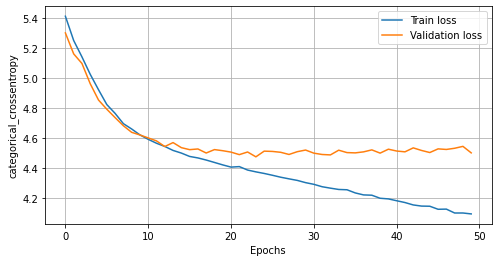

In [ ]:
loss_plot(history)

**Testing**

In [ ]:
model_train.load(checkpoint_path)
means, vars = model_train.uncertainty(200)

In [ ]:
print("Coverage": np.unique(np.argmax(means, axis=1)).shape)

In [ ]:
model_train.topk_accuracy([1,2,5], means)

array([0.08386076, 0.13212025, 0.21716772])

## 4.2 LSTM

In [ ]:
model_train = Train_model(11) #assign object
model_train.data_prepare(32, "koa_pkl", kfold=0, smoothing=0.3) # prepare data for training or testing

In [ ]:
tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)

In [ ]:
embed = "koa_Doc2Vec"
model = Model_LSTM(dim=128, reg=None)
LSTM_train = build_lstm(model_train, embed, 0.4, 1e-4, model)

In [ ]:
LSTM_train.summary()

In [ ]:
checkpoint_path = "Checkpoints/"+embed+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor="val_loss",
    verbose=1, save_best_only=True)

In [ ]:
history = LSTM_train.fit(model_train.train_dataset, steps_per_epoch=model_train.steps, epochs = 50,
                validation_data = model_train.val_dataset, callbacks=[cp_callback],verbose=0)

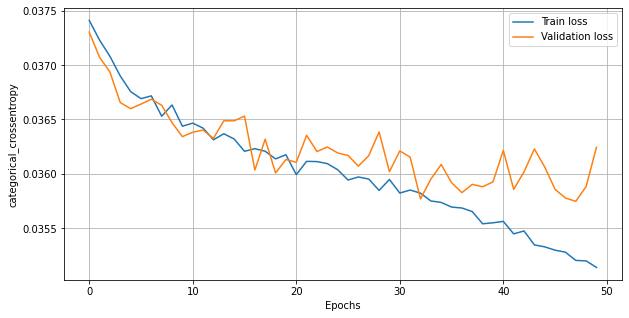

In [ ]:
loss_plot(history)

**Testing**

In [ ]:
model_train.load(checkpoint_path)
means, vars = model_train.uncertainty(200)

In [ ]:
print("Coverage:", np.unique(np.argmax(means, axis=1)).shape)

Coverage: (129,)


In [ ]:
model_train.topk_accuracy([1,2,5], means)

array([0.08821203, 0.13291139, 0.2278481 ])

## 4.3 Transformer

In [ ]:
model_train = Train_model(11) #assign object
model_train.data_prepare(32, "movie_pkl_2.5w", kfold=0, smoothing=0.1) # prepare data for training or testing

In [ ]:
embed = "movie_Doc2Vec"
transformer_train = build_transformer(model_train, embed, 1, 4, 128, 0.2, 1e-4)

In [ ]:
transformer_train.summary()

In [ ]:
checkpoint_path = "Checkpoints/"+embed+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor="val_loss",
    verbose=1, save_best_only=True)

In [ ]:
history = transformer_train.fit(model_train.train_dataset, steps_per_epoch=model_train.steps, epochs = 50,
                validation_data = model_train.val_dataset, callbacks=[cp_callback],verbose=0)

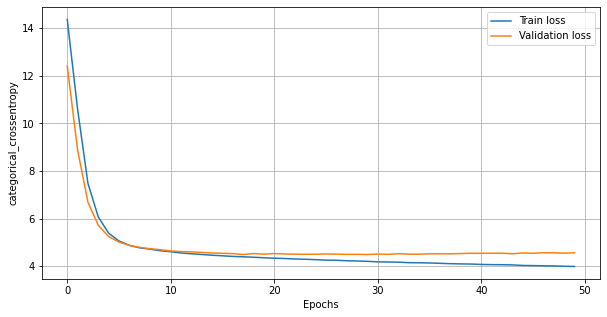

In [ ]:
loss_plot(history)

**Testing**

In [ ]:
records = []

In [ ]:
model_train.load(checkpoint_path)
means, vars = model_train.uncertainty(200)
hard = model_train.topk_accuracy([1,2,5], means)
soft = model_train.soft_evaluation(means)

In [ ]:
np.mean(vars)

2.4117384e-05

In [ ]:
print("Coverage:", np.unique(np.argmax(means, axis=1)).shape)

Coverage: (86,)


In [ ]:
records.append((hard, soft))

In [ ]:
records

[(array([0.11392405, 0.16337025, 0.26542722]), 0.3276832805907173),
 (array([0.12183544, 0.17128165, 0.26661392]), 0.3242220464135021)]

##4.4 Cross evaluation

In [ ]:
koa_train = Train_model(11)
params = {"LSTM": [Model_LSTM(dim=256, reg=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)), False, False],
          "Transformer": [1, 4, 256]}
model_name = "NN"

In [ ]:
def cross_evaluation(obj, batch_size, dataset, embedding, dropout, lr, model_name, params):
  mapp = {"evaluations": [],
          "soft_evaluations": [],
          "model_vars": [],
          "model_coverage": []}

  obj.get_embedding(embedding)
  for fold_k in range(1, 6):
    obj.data_prepare(batch_size, dataset=dataset, kfold=fold_k)
    if model_name == "LSTM":
      network, time_dif, focus_area = params["LSTM"]
      model_train = obj.build_LSTM(network, dropout, lr, time_dif, focus_area)
    elif model_name == "NN":
      model_train = obj.build_NN(dropout, lr)
    else:
      num_layers, num_heads, dff = params["Transformer"]
      model_train = obj.build_Transformer(num_layers, num_heads, dff, dropout, lr)

    checkpoint_path = "Checkpoints/"+embedding+"/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor="val_loss",
        verbose=1, save_best_only=True)
    
    model_train.fit(obj.train_dataset, steps_per_epoch=obj.steps, epochs = 100,
                validation_data = obj.val_dataset, callbacks=[cp_callback], verbose=0)
    obj.load(checkpoint_path)
    means, vars = obj.uncertainty(200)
    evaluation = obj.topk_accuracy([1,2,5], means)
    soft_evaluation = obj.soft_evaluation(means)
    model_var = np.mean(vars)
    model_cover = np.unique(np.argmax(means, axis=1)).shape

    mapp["model_coverage"].append(model_cover)
    mapp["model_vars"].append(model_var)
    mapp["soft_evaluations"].append(soft_evaluation)
    mapp["evaluations"].append(evaluation)
  return mapp

In [ ]:
results = cross_evaluation(koa_train, 16, "koa_pkl", "koa_Doc2Vec", 0.3, 1e-4, model_name, params)

In [ ]:
results

{'evaluations': [array([0.0625  , 0.09375 , 0.171875]),
  array([0.109375, 0.125   , 0.171875]),
  array([0.0625 , 0.09375, 0.25   ]),
  array([0.125  , 0.15625, 0.3125 ]),
  array([0.046875, 0.078125, 0.171875])],
 'soft_evaluations': [0.30963541666666666,
  0.35468750000000004,
  0.30781250000000004,
  0.4375,
  0.3809895833333333],
 'model_vars': [4.0531795e-05,
  2.5831909e-05,
  2.9038112e-05,
  4.8504768e-05,
  6.708542e-05],
 'model_coverage': [(2,), (1,), (1,), (1,), (3,)]}

In [ ]:
np.mean(results["evaluations"], axis=0), np.mean(results["soft_evaluations"]), np.mean(results["model_vars"])

(array([0.08125 , 0.109375, 0.215625]), 0.35812499999999997, 4.21984e-05)

## 4.5 Uncertainty plot

In [ ]:
def plot_uncertainty(user_idx,means,vars,act_size):
  m = np.squeeze(means[user_idx])
  v = np.squeeze(vars[user_idx])


  fig, ax = plt.subplots(figsize=(30, 7))

  plt.errorbar(range(0,act_size+1,1), m, yerr=2*v**0.5, fmt='o', color='cornflowerblue',
             ecolor='lightgray', elinewidth=3, capsize=0)
  plt.ylabel('Probabilities', fontsize=10)
  plt.xlabel('Activity labels', fontsize=10)
  plt.grid()

## 4.6 PopAct baseline

In [ ]:
def pop_act_topk_accuracy(model, k, top_act_num):

  train_np = np.stack(list(model.train_dataset))
  val_np = np.stack(list(model.val_dataset))
  train_list = []
  targets = []

  for i in range(train_np.shape[0]):
    train_list.extend(train_np[i][0]['act_id'].numpy().flatten())
    train_list.extend(train_np[i][1].numpy().flatten())

  for i in range(val_np.shape[0]):
    targets.extend(val_np[i][1].numpy().flatten())
  targets.extend(model.target_test)

  train_list = pd.DataFrame(train_list)

  distribution = (train_list.value_counts()[1:top_act_num+1]/sum(train_list.value_counts()[1:top_act_num+1])).to_list()
  index = train_list.value_counts().keys()[1:top_act_num+1]
  index = [index[i][0] for i in range(index.shape[0])]

  corrects = 0
  for i in range(len(targets)):
    label = targets[i]
    ind = [np.random.choice(index, p=distribution, replace = False) for i in range(k)]
    if label in ind:
        corrects += 1
  return corrects/len(targets)